In [5]:
"""
Training script for the GNN
"""

import os
import json
import time
import numpy as np
import pickle as pkl
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch_geometric.loader import DataLoader

In [13]:
import sys
from pathlib import Path

# Get the absolute path to the parent directory
project_path = Path('.').resolve()

# Add it to the sys.path
if str(project_path) not in sys.path:
    sys.path.append(str(project_path))

In [16]:
import os
print(os.getcwd())

/Users/briandepasquale/Documents/GitHub/fish_dynamics/notebook


In [17]:
os.chdir('/Users/briandepasquale/Documents/GitHub/fish_dynamics')
print(os.getcwd())  # Verify the change

/Users/briandepasquale/Documents/GitHub/fish_dynamics


In [18]:
from model.gnn import MPNN, EGNN
import graph_utils.utils as gu

In [25]:
def train(datasets, plot_loss=True, save_model=True, model_type='egnn'):
    # load datasets of interest
    data_list = []
    for dataset in datasets:
        data_list += pkl.load(open(dataset, 'rb'))

    # split into train and test
    train, val, test = gu.train_val_test(data_list)

    # get model config
    config = json.load(open('model/config.json', 'r'))

    # init model
    if model_type == 'mpnn':
        model = MPNN(
            noise_std=config['noise_std'],
            mp_mlp_hidden_dim=config['mp_mlp_hidden_dim'],
            update_mlp_hidden_dim=config['update_mlp_hidden_dim']
        )

    elif model_type == 'egnn':
        model = EGNN(
            num_fish=train[0].x.shape[0],
            batch_size=config['batch_size'],
            noise_std=config['noise_std'],
            mlp_hidden_dim=config['mp_mlp_hidden_dim'],
            mlp_depth=config['mlp_depth']
        )

    model.train()
    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=config['adam_lr'])

    # training loop
    loss_vals = []
    dataloader = DataLoader(
        train,
        batch_size=config['batch_size'],
        shuffle=True
    )
    for i in tqdm(range(config['epochs'])):
        epoch_loss = []
        for g in dataloader:
            opt.zero_grad()

            # foraward pass
            out = model(
                x=g.x,
                edge_index=g.edge_index,
                edge_attr=g.edge_attr,
                pos=g.pos
            )

            if model_type == 'mpnn':
                loss = loss_fn(out, g.acc)

            elif model_type == 'egnn':
                loss = loss_fn(out, g.pos_next)

            # backward pass
            loss.backward()
            opt.step()

            # record keeping
            loss_vals.append(loss.item())
            epoch_loss.append(loss.item())

        # loss per epoch
        print(f'epoch {i} loss: {np.mean(epoch_loss)}')

    # post processing model
    if plot_loss:
        gu.plot_loss(loss_vals)
        gu.plot_loss(epoch_loss)
        plt.show()

    if save_model:
        fp = './results/saved models'  # TODO: add option to specify model name
        file = os.path.join(fp, f'tmp{round(time.time())}.pt')
        torch.save(
            {
                'model': model.state_dict(),
                'datasets': datasets,
                'config': config,
                'loss': loss_vals,
                'model_type': model_type
            },
            file
        )

In [26]:
print(os.getcwd())

/Users/briandepasquale/Documents/GitHub/fish_dynamics


  1%|          | 1/100 [00:07<12:54,  7.82s/it]

epoch 0 loss: 346.04232482374914


  2%|▏         | 2/100 [00:15<12:49,  7.86s/it]

epoch 1 loss: 200.38246729843877


  3%|▎         | 3/100 [00:23<12:35,  7.78s/it]

epoch 2 loss: 3.98468260183637


  4%|▍         | 4/100 [00:31<12:30,  7.81s/it]

epoch 3 loss: 62.611960581539314


  5%|▌         | 5/100 [00:39<12:23,  7.82s/it]

epoch 4 loss: 80.37027074884784


  6%|▌         | 6/100 [00:46<12:15,  7.82s/it]

epoch 5 loss: 9.063311283083754


  7%|▋         | 7/100 [00:54<12:06,  7.82s/it]

epoch 6 loss: 59.242215963833544


  8%|▊         | 8/100 [01:03<12:28,  8.13s/it]

epoch 7 loss: 28.25594337602315


  9%|▉         | 9/100 [01:11<12:18,  8.11s/it]

epoch 8 loss: 19.966828072675362


 10%|█         | 10/100 [01:19<11:59,  7.99s/it]

epoch 9 loss: 18.044750800143238


 11%|█         | 11/100 [01:27<11:47,  7.95s/it]

epoch 10 loss: 4.508115364328358


 12%|█▏        | 12/100 [01:35<11:37,  7.92s/it]

epoch 11 loss: 7.597703320820511


 13%|█▎        | 13/100 [01:43<11:34,  7.99s/it]

epoch 12 loss: 2.2070170937969835


 14%|█▍        | 14/100 [01:51<11:34,  8.07s/it]

epoch 13 loss: 7.066991801185991


 15%|█▌        | 15/100 [01:59<11:28,  8.10s/it]

epoch 14 loss: 3.8799865148652533


 16%|█▌        | 16/100 [02:08<11:30,  8.22s/it]

epoch 15 loss: 1.8528826704297947


 17%|█▋        | 17/100 [02:16<11:35,  8.38s/it]

epoch 16 loss: 4.378053433097553


 18%|█▊        | 18/100 [02:24<11:16,  8.25s/it]

epoch 17 loss: 1.6306502267524794


 19%|█▉        | 19/100 [02:32<11:06,  8.23s/it]

epoch 18 loss: 2.187194463235467


 20%|██        | 20/100 [02:40<10:52,  8.16s/it]

epoch 19 loss: 0.4581981013896928


 21%|██        | 21/100 [02:48<10:39,  8.10s/it]

epoch 20 loss: 2.0316682610025603


 22%|██▏       | 22/100 [02:56<10:24,  8.01s/it]

epoch 21 loss: 0.509176898430869


 23%|██▎       | 23/100 [03:04<10:12,  7.96s/it]

epoch 22 loss: 0.7337721214166585


 24%|██▍       | 24/100 [03:12<10:04,  7.95s/it]

epoch 23 loss: 0.5055578062486389


 25%|██▌       | 25/100 [03:20<09:52,  7.91s/it]

epoch 24 loss: 0.4954284256254723


 26%|██▌       | 26/100 [03:29<10:09,  8.24s/it]

epoch 25 loss: 0.4866511595201732


 27%|██▋       | 27/100 [03:37<09:55,  8.16s/it]

epoch 26 loss: 0.45137487210186644


 28%|██▊       | 28/100 [03:45<09:39,  8.05s/it]

epoch 27 loss: 0.40884795547106


 29%|██▉       | 29/100 [03:52<09:27,  8.00s/it]

epoch 28 loss: 0.4002934970901159


 30%|███       | 30/100 [04:00<09:15,  7.94s/it]

epoch 29 loss: 0.3930383415640674


 31%|███       | 31/100 [04:08<09:02,  7.86s/it]

epoch 30 loss: 0.38973669153429447


 32%|███▏      | 32/100 [04:16<08:51,  7.82s/it]

epoch 31 loss: 0.40801283645365194


 33%|███▎      | 33/100 [04:23<08:43,  7.81s/it]

epoch 32 loss: 0.39242845096995654


 34%|███▍      | 34/100 [04:31<08:34,  7.80s/it]

epoch 33 loss: 0.3874751756417986


 35%|███▌      | 35/100 [04:39<08:26,  7.79s/it]

epoch 34 loss: 0.38748102273072565


 36%|███▌      | 36/100 [04:47<08:17,  7.77s/it]

epoch 35 loss: 0.38747806750646835


 37%|███▋      | 37/100 [04:54<08:07,  7.74s/it]

epoch 36 loss: 0.39618485688439065


 38%|███▊      | 38/100 [05:02<08:00,  7.74s/it]

epoch 37 loss: 0.38903971779256574


 39%|███▉      | 39/100 [05:10<07:52,  7.75s/it]

epoch 38 loss: 0.396003238753789


 40%|████      | 40/100 [05:18<07:44,  7.74s/it]

epoch 39 loss: 0.39640859410535056


 41%|████      | 41/100 [05:25<07:36,  7.74s/it]

epoch 40 loss: 0.38752355832633084


 42%|████▏     | 42/100 [05:33<07:29,  7.74s/it]

epoch 41 loss: 0.3874848655291966


 43%|████▎     | 43/100 [05:41<07:21,  7.75s/it]

epoch 42 loss: 0.38747878524365165


 44%|████▍     | 44/100 [05:49<07:13,  7.73s/it]

epoch 43 loss: 0.38934278763459224


 45%|████▌     | 45/100 [05:56<07:06,  7.75s/it]

epoch 44 loss: 0.38748400346861755


 46%|████▌     | 46/100 [06:04<06:58,  7.75s/it]

epoch 45 loss: 0.38747647003893776


 47%|████▋     | 47/100 [06:12<06:49,  7.73s/it]

epoch 46 loss: 0.3874773012421897


 48%|████▊     | 48/100 [06:20<06:41,  7.73s/it]

epoch 47 loss: 0.3875036804051543


 49%|████▉     | 49/100 [06:27<06:34,  7.74s/it]

epoch 48 loss: 0.3874888271124582


 50%|█████     | 50/100 [06:35<06:26,  7.73s/it]

epoch 49 loss: 0.39282215974997114


 51%|█████     | 51/100 [06:43<06:18,  7.72s/it]

epoch 50 loss: 0.44557225789717164


 52%|█████▏    | 52/100 [06:50<06:10,  7.72s/it]

epoch 51 loss: 0.3874824644602089


 53%|█████▎    | 53/100 [06:58<06:03,  7.73s/it]

epoch 52 loss: 0.38750859581879804


 54%|█████▍    | 54/100 [07:06<05:55,  7.72s/it]

epoch 53 loss: 0.38749455965534135


 55%|█████▌    | 55/100 [07:14<05:47,  7.72s/it]

epoch 54 loss: 0.38751845930129053


 56%|█████▌    | 56/100 [07:21<05:40,  7.74s/it]

epoch 55 loss: 0.3885439406373434


 57%|█████▋    | 57/100 [07:29<05:32,  7.73s/it]

epoch 56 loss: 0.3875072920577118


 58%|█████▊    | 58/100 [07:37<05:24,  7.73s/it]

epoch 57 loss: 0.3875464641328731


 59%|█████▉    | 59/100 [07:45<05:16,  7.71s/it]

epoch 58 loss: 0.38806114331743036


 60%|██████    | 60/100 [07:52<05:08,  7.70s/it]

epoch 59 loss: 0.38753836594793556


 61%|██████    | 61/100 [08:00<05:00,  7.71s/it]

epoch 60 loss: 0.38749859619699967


 62%|██████▏   | 62/100 [08:08<04:53,  7.72s/it]

epoch 61 loss: 0.38748089413563974


 63%|██████▎   | 63/100 [08:15<04:45,  7.72s/it]

epoch 62 loss: 0.3875007430691573


 64%|██████▍   | 64/100 [08:23<04:37,  7.70s/it]

epoch 63 loss: 0.38790191484636277


 65%|██████▌   | 65/100 [08:31<04:29,  7.71s/it]

epoch 64 loss: 0.3875725905629047


 66%|██████▌   | 66/100 [08:38<04:21,  7.70s/it]

epoch 65 loss: 0.3875412373898366


 67%|██████▋   | 67/100 [08:46<04:13,  7.69s/it]

epoch 66 loss: 0.38749333492596877


 68%|██████▊   | 68/100 [08:54<04:06,  7.70s/it]

epoch 67 loss: 0.39381856008409005


 69%|██████▉   | 69/100 [09:02<03:58,  7.70s/it]

epoch 68 loss: 0.387514447059075


 70%|███████   | 70/100 [09:09<03:50,  7.70s/it]

epoch 69 loss: 0.39592612387123194


 71%|███████   | 71/100 [09:17<03:44,  7.75s/it]

epoch 70 loss: 0.3875252864802288


 72%|███████▏  | 72/100 [09:25<03:37,  7.79s/it]

epoch 71 loss: 0.3874855127683433


 73%|███████▎  | 73/100 [09:33<03:29,  7.77s/it]

epoch 72 loss: 0.3874774694561359


 74%|███████▍  | 74/100 [09:40<03:21,  7.77s/it]

epoch 73 loss: 0.38757344516978187


 75%|███████▌  | 75/100 [09:48<03:13,  7.76s/it]

epoch 74 loss: 0.3887887580104088


 76%|███████▌  | 76/100 [09:56<03:05,  7.74s/it]

epoch 75 loss: 0.39755170471157847


 77%|███████▋  | 77/100 [10:04<02:57,  7.74s/it]

epoch 76 loss: 0.38751990626834154


 78%|███████▊  | 78/100 [10:11<02:50,  7.76s/it]

epoch 77 loss: 0.3874999319203588


 79%|███████▉  | 79/100 [10:19<02:42,  7.74s/it]

epoch 78 loss: 0.39287974470059744


 80%|████████  | 80/100 [10:27<02:34,  7.73s/it]

epoch 79 loss: 0.38749473375608895


 81%|████████  | 81/100 [10:35<02:26,  7.72s/it]

epoch 80 loss: 0.38752867773980537


 82%|████████▏ | 82/100 [10:42<02:18,  7.72s/it]

epoch 81 loss: 0.38915463850669996


 83%|████████▎ | 83/100 [10:50<02:11,  7.71s/it]

epoch 82 loss: 0.3874756354802715


 84%|████████▍ | 84/100 [10:58<02:03,  7.71s/it]

epoch 83 loss: 0.39090685054166674


 85%|████████▌ | 85/100 [11:05<01:56,  7.76s/it]

epoch 84 loss: 0.3880161480095579


 86%|████████▌ | 86/100 [11:13<01:48,  7.74s/it]

epoch 85 loss: 0.38748966794809037


 87%|████████▋ | 87/100 [11:21<01:40,  7.74s/it]

epoch 86 loss: 0.3899484440078783


 88%|████████▊ | 88/100 [11:29<01:32,  7.74s/it]

epoch 87 loss: 0.38748428903467047


 89%|████████▉ | 89/100 [11:36<01:25,  7.75s/it]

epoch 88 loss: 0.38749263774577075


 90%|█████████ | 90/100 [11:44<01:17,  7.78s/it]

epoch 89 loss: 0.3881646869107176


 91%|█████████ | 91/100 [11:52<01:10,  7.78s/it]

epoch 90 loss: 0.387637021523367


 92%|█████████▏| 92/100 [12:00<01:02,  7.78s/it]

epoch 91 loss: 0.38808418588129906


 93%|█████████▎| 93/100 [12:08<00:54,  7.78s/it]

epoch 92 loss: 0.3874869044912276


 94%|█████████▍| 94/100 [12:15<00:46,  7.77s/it]

epoch 93 loss: 0.3875084677012735


 95%|█████████▌| 95/100 [12:23<00:38,  7.77s/it]

epoch 94 loss: 0.3874840165781435


 96%|█████████▌| 96/100 [12:31<00:31,  7.76s/it]

epoch 95 loss: 0.3875071378397452


 97%|█████████▋| 97/100 [12:39<00:23,  7.76s/it]

epoch 96 loss: 0.3907847572874963


 98%|█████████▊| 98/100 [12:46<00:15,  7.74s/it]

epoch 97 loss: 0.38753273684233364


 99%|█████████▉| 99/100 [12:54<00:07,  7.77s/it]

epoch 98 loss: 0.38838972585142334


100%|██████████| 100/100 [22:11<00:00, 13.31s/it] 

epoch 99 loss: 0.38751167556482424


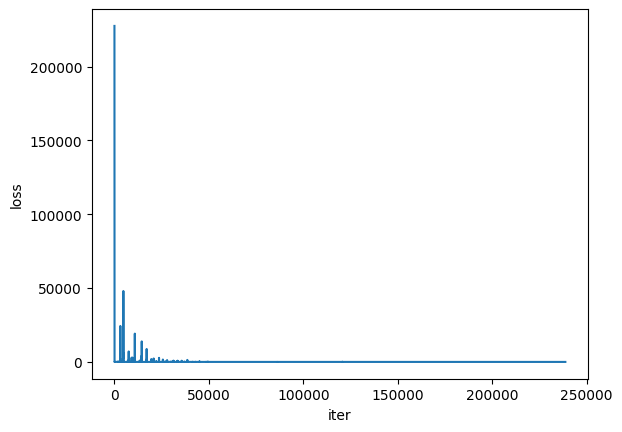

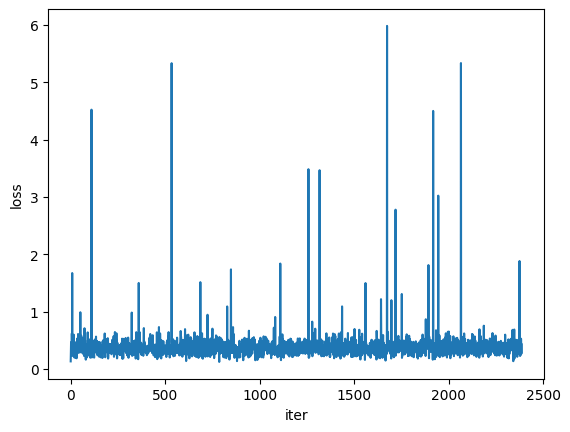

In [27]:

datasets = ['./Processed Fish Data/data/processed/8fish/240816f4.pkl']
train(datasets=datasets)
